In [ ]:
model = "Stable Diffusion 1.5" #@param ["Stable Diffusion 1.5", "Dreamlike Diffusion", "Anything v3.0", "Anything v4.0", "Waifu Diffusion 1.3", "Pastel Waifu Diffusion", "Inkpunk Diffusion", "Vivid Watercolors", "Furry Diffusion"] {type:"string"}
model = "Pastel Waifu Diffusion"

prompt = "A character sheet of an anime girl"
negative_prompt = ""
number_of_images = 1 #@param {type:"integer"}
steps = 20 #@param {type:"integer"}
sampler = "Euler a" #@param ["Euler a", "Euler", "KLMS", "DPMSolver++ (2S) (has issues with img2img)", "DPMSolver++ (2M)", "UniPC"] 
guidance_scale = 7 #@param {type:"slider", min:0, max:20, step:0.5}
seed = -1 #@param {type:"integer"}   

add_standard_danbooru_model_quality_prompts = False #@param {type: "boolean"}
add_automatic_keyword = True #@param {type: "boolean"}

######

test_mode = True
enable_attention_slicing = False
enable_xformers = True
enable_gpu_offload = False
%env PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6,max_split_size_mb:128
from IPython.display import display, clear_output

try:
  import torch
  %cd /content/simplest-stable/
  import src
except ImportError as e:
  import os, subprocess
  %cd /content/
  subprocess.run(["git", "clone", "https://github.com/cadaeix/simplest-stable.git"])
  %cd /content/simplest-stable/
  if test_mode:
    subprocess.run(["git", "checkout", "test-branch"])
  if enable_xformers:
    subprocess.run(['pip', 'install', 'triton==2.0.0.dev20221202', 'xformers==0.0.16rc424'])
  subprocess.run(["pip3", "install", "-r", "requirements.txt"])
  downloaded_embeds_path = None

import os, subprocess, sys, json, logging
from diffusers import ControlNetModel
import torch
import json
from PIL import Image
from src.utils import free_ram
from src.loading import load_diffusers_model_with_controlnet
from src.process import process_and_generate

logging.disable(sys.maxsize)
clear_output(wait=False)

try:
  outputs_folder
  if not os.path.exists(outputs_folder):
      os.mkdirs(outputs_folder)
  session_folder = outputs_folder
except NameError as e:
  outputs_path = "images/"
  if not os.path.exists(outputs_path):
      os.mkdir(outputs_path)
      
  print(f"Outputs will be saved to {outputs_path}.")
  session_folder = os.path.join(outputs_path, datetime.now().strftime("%Y_%m_%d"))
  if not os.path.exists(session_folder):
      os.mkdir(session_folder)

try:
  model_dict
except NameError as e:
  with open('src/resources/models.json') as modelfile:
      model_dict = json.load(modelfile)
  del modelfile

try: 
  custom_randomizer_folder
  if os.path.exists(custom_randomizer_folder):
    randomizers = get_random_lists_from_folder(custom_randomizer_folder)
    randomizers = {**default_randomizers, **randomizers}
  else:
    randomizers = default_randomizers
except NameError as e:
  randomizers = default_randomizers

pose_sheet = Image.open("src/resources/char_sheet_pose.png").convert('RGB')
width = 768
height = 512

recreate = False
try:
  controlnet
  pipe
  recreate = model_name != model
  if recreate:
    del pipe
    free_ram()
except NameError as e:
  pipe = None
  controlnet = None
  recreate = True

if recreate:
    controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
    pipe = load_diffusers_model_with_controlnet(model_dict[model], controlnet)
    if enable_gpu_offload:
        pipe.enable_model_cpu_offload()
    else:
        pipe.to("cuda")

if add_standard_danbooru_model_quality_prompts:
    prompt = "masterpiece, best quality, " + prompt
    standard_negative = "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username"
    negative_prompt = standard_negative if negative_prompt is None or negative_prompt is "" else standard_negative + ", " + negative_prompt

opt = {
    "model_name" : model,
    "eta" : 0.0,
    "steps" : steps,
    "init_img" : None,
    "mask_image": None,
    "number_of_images": number_of_images,
    "prompt" : prompt,
    "negative" : negative_prompt,
    "sampler" : sampler,
    "scale" : guidance_scale,
    "seed" : seed,
    "strength" : None,
    "H" : 512,
    "W" : 768,
    #upscale stuff
    "passes" : 1,
    "upscale": False,
    "upscale_strength" : 0,
    "detail_scale" : 10,
    "add_keyword": add_automatic_keyword,
    "prediction_type": model_dict[model]["prediction"],
    "keyword": model_dict[model].get("keyword"),
    "negative_keyword": model_dict[model].get("negative_keyword"),
    "outputs_folder": session_folder,
    "program_version": "Simple Stable 2.0 (Notebook, pre-release 20230129)"
    }

try:
  pipe, images, images_details = process_and_generate(
    opt = opt,
    pipe = pipe, 
    progress=None,
    randomizer = randomizers,
    display_and_print=True
    )
except Exception as e:
  print(f"Generation of images failed for some reason, try loading another model. If that doesn't work, go to Runtime -> Disconnect and Delete Runtime and then rerun this cell, and then if that fails, take a screenshot or copy the error below and ask @Cadaeic about it!")
  raise e


safety_checker\model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

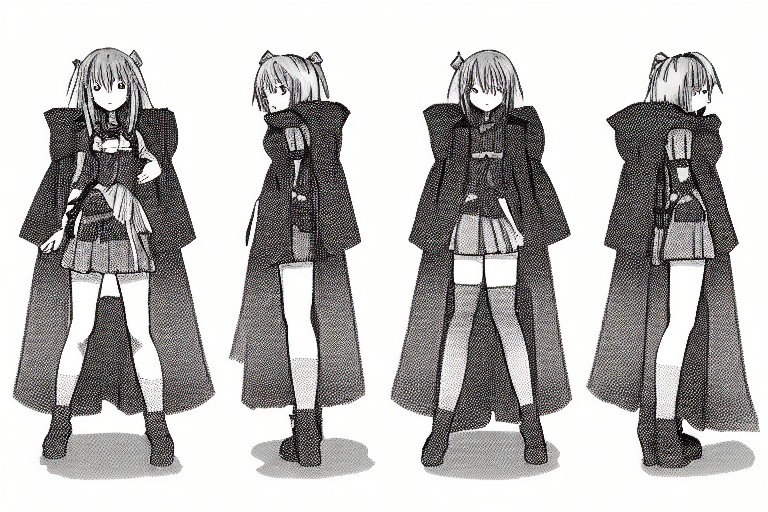

In [12]:
from src.SimpleStableDiffusionControlNetPipeline import SimpleStableDiffusionControlNetPipeline
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from PIL import Image
from src.utils import load_img_for_upscale

pose_sheet = Image.open("char_sheet_pose.png").convert('RGB')
base = Image.open("character_sheet_base.png").convert('RGB')
width = 768
height = 512

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
pipe = SimpleStableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.to("cuda")
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

prompt_options = {
    "prompt": "A character sheet of an anime girl",
    "negative_prompt": "",
    "controlnet_image": pose_sheet,
    "height": height,
    "width": width,
    "num_inference_steps": 20,
    "guidance_scale": 7,
    "num_images_per_prompt": 1,
    "eta": 1,
    "strength": 1
}

image = pipe(**prompt_options).images[0]
display(image)
